### F1 Prédiction des temps des 5 tours suivants

Dans ce notebook, je vais rapidement tenter de prédire le temps au tour des pilotes en utilsiant la donnée disponible en ligne.
Toute ma donnée est issue du kaggle : https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

Ce notebook arrive dans la continuité d'une première étude expliquée dans ce pdf : https://github.com/HenriEloy/F1_lapTime_prediction/blob/main/F1%20Lap%20Time%20Prediction.pdf

Cependant, suite aux conseils d'un collègue, j'ai voulu explorer l'utilisaiton d'XGBoost pour résoudre ce problème.

In [474]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import warnings
import requests
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import TimeSeriesSplit
warnings.filterwarnings("ignore")

#### L'import

J'importe ici les 5 datasets qui me permettront de construire mon dataset à entraîner. La data est composée exclusivements d'informations publiques transmises par la F1 (temps au tour, arrets aux stands, etc.)

In [475]:
lap_times = pd.read_csv("../data/lap_times.csv")
pit_stops = pd.read_csv("../data/pit_stops.csv")
races = pd.read_csv("../data/races.csv")
drivers = pd.read_csv("../data/drivers.csv")
circuits = pd.read_csv("../data/circuits.csv")

In [476]:
lap_times["len"] = [len(i) for i in lap_times["time"]]
lap_times = (lap_times
             .rename(columns={"time":"lap_time"})
             .drop(lap_times[lap_times["len"]!=8].index)
             .drop(columns=["len"])
)

lap_times["lap_time"] = pd.to_timedelta("00:"+lap_times["lap_time"])

lap_times.head()

,raceId,driverId,lap,position,lap_time,milliseconds
0,841,20,1,1,0 days 00:01:38.109000,98109
1,841,20,2,1,0 days 00:01:33.006000,93006
2,841,20,3,1,0 days 00:01:32.713000,92713
3,841,20,4,1,0 days 00:01:32.803000,92803
4,841,20,5,1,0 days 00:01:32.342000,92342


In [477]:
races = (races[["raceId", "year","round", "circuitId","name", "date","time"]]
         .rename(columns={
             "name":"race_name",
             "time":"race_time"
         })
         .dropna())
races.head()

,raceId,year,round,circuitId,race_name,date,race_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00


In [478]:
drivers = drivers.assign(fullname = drivers["forename"] + " " + drivers["surname"]).dropna()[["driverId", "driverRef", "fullname"]]
#drivers.head()
drivers[drivers["driverRef"]=="ocon"]

,driverId,driverRef,fullname
838,839,ocon,Esteban Ocon


In [479]:
pit_stops = pit_stops.rename(columns={"time":"stop_time", "milliseconds":"stop_ms"}).dropna()
pit_stops.head()

,raceId,driverId,stop,lap,stop_time,duration,stop_ms
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


In [480]:
circuits = circuits[["circuitId", "name", "lat", "lng"]].rename(columns={"name":"circuit_name"}).dropna()
circuits["coods"] = circuits["lat"].astype(str)+","+circuits["lng"].astype(str)
circuits.head()

,circuitId,circuit_name,lat,lng,coods
0,1,Albert Park Grand Prix Circuit,-37.84970,144.96800,"-37.8497,144.968"
1,2,Sepang International Circuit,2.76083,101.73800,"2.76083,101.738"
2,3,Bahrain International Circuit,26.03250,50.51060,"26.0325,50.5106"
3,4,Circuit de Barcelona-Catalunya,41.57000,2.26111,"41.57,2.26111"
4,5,Istanbul Park,40.95170,29.40500,"40.9517,29.405"


#### La jointure des datasets

Nous allons joindre tous les datasets afin d'obtenir une table prête à être entrainée avec XGBoost 

In [481]:
df_merged = pd.merge(lap_times, races, on='raceId')

df_merged.replace('\\N', pd.NaT, inplace=True)

df_merged.dropna(inplace=True)

df_merged2 = df_merged.assign(lap_hour=0).groupby("raceId")

merge = []
for name,group in df_merged2:
    group = group.reset_index(drop=True)
    startDT = pd.to_datetime(group["date"][0] + " " + group["race_time"][0])
    for i in group.index:
        if i == 0 :
            group["lap_hour"][i] = startDT + pd.to_timedelta(group["lap_time"][i])
        else :
            group["lap_hour"][i] = group["lap_hour"][i-1] + group["lap_time"][i]
    merge.append(group)

df_merged2 = pd.concat(merge)[["raceId", "circuitId", "driverId", "lap","year", "round", "milliseconds"]]

df_merged2.head()

,raceId,circuitId,driverId,lap,year,round,milliseconds
0,1,1,1,1,2009,1,109088
1,1,1,1,2,2009,1,93740
2,1,1,1,3,2009,1,91600
3,1,1,1,4,2009,1,91067
4,1,1,1,5,2009,1,92129


In [482]:
#ajout des pits stops

df_merged = pd.merge(df_merged2, pit_stops, on=['raceId',"lap", "driverId"], how="left")

#On supprime les courses sans pitstops

listGpPit = pit_stops["raceId"].unique()
df_merged = df_merged[df_merged['raceId'].isin(listGpPit)]
df_merged.reset_index(drop=True, inplace=True)

df_merged = df_merged[["raceId", "circuitId", "driverId", "lap","year", "round", "milliseconds","stop"]].rename(columns={"stop":"nb_stop"})


df_merged

,raceId,circuitId,driverId,lap,year,round,milliseconds,nb_stop
0,841,1,20,1,2011,1,98109,NaN
1,841,1,20,2,2011,1,93006,NaN
2,841,1,20,3,2011,1,92713,NaN
3,841,1,20,4,2011,1,92803,NaN
4,841,1,20,5,2011,1,92342,NaN
...,...,...,...,...,...,...,...,...
268875,1096,24,822,53,2022,22,92998,NaN
268876,1096,24,822,54,2022,22,92995,NaN
268877,1096,24,822,55,2022,22,91236,NaN
268878,1096,24,822,56,2022,22,90566,NaN


In [483]:
df = df_merged.copy()
df["stop"]=False
df.loc[~df['nb_stop'].isna(), 'stop'] = True #Booleen expliquant la présence d'un arret
df['nb_stop'] = df.groupby(['raceId', 'driverId'])['nb_stop'].fillna(method='ffill') #On remplit les NaN avec la dernière valeur du stop (par pilote et par course)
df['nb_stop'] = df['nb_stop'].fillna(0).astype(int)
df

,raceId,circuitId,driverId,lap,year,round,milliseconds,nb_stop,stop
0,841,1,20,1,2011,1,98109,0,False
1,841,1,20,2,2011,1,93006,0,False
2,841,1,20,3,2011,1,92713,0,False
3,841,1,20,4,2011,1,92803,0,False
4,841,1,20,5,2011,1,92342,0,False
...,...,...,...,...,...,...,...,...,...
268875,1096,24,822,53,2022,22,92998,1,False
268876,1096,24,822,54,2022,22,92995,1,False
268877,1096,24,822,55,2022,22,91236,1,False
268878,1096,24,822,56,2022,22,90566,1,False


In [484]:
#On ajoute une colonne qui compte les tours depuis le dernier arret

df["laps_since_last_stop"] = 0
df_merged2 = pd.DataFrame()
for (raceId, driverId), df3 in df.groupby(["raceId", "driverId"]):
    cnt = 0
    nbStop = 0
    for i, row in df3.iterrows():
        cnt += 1
        if row["stop"] == nbStop:
            df3.at[i, "laps_since_last_stop"] = cnt
        else:
            nbStop += 1
            cnt = 0
    df_merged2 = pd.concat([df_merged2, df3], ignore_index=True)
df_merged2

,raceId,circuitId,driverId,lap,year,round,milliseconds,nb_stop,stop,laps_since_last_stop
0,841,1,1,1,2011,1,100573,0,False,1
1,841,1,1,2,2011,1,93774,0,False,2
2,841,1,1,3,2011,1,92900,0,False,3
3,841,1,1,4,2011,1,92582,0,False,4
4,841,1,1,5,2011,1,92471,0,False,5
...,...,...,...,...,...,...,...,...,...,...
268875,1096,24,855,53,2022,22,89600,2,False,0
268876,1096,24,855,54,2022,22,90422,2,False,0
268877,1096,24,855,55,2022,22,90407,2,False,0
268878,1096,24,855,56,2022,22,92315,2,False,0


#### Les shifts (ou lag)

Ici, nous allons ajouter à chaque tour de course 5 colonnes, représentant les 5 prochains tours.
Plus tard, ce sont ces 5 colonnes que nous chercherons à prédire à partir du reste des attributs de la ligne.

In [485]:
df_merged2["y+1"] = df_merged2.groupby(["raceId","driverId"])["milliseconds"].shift(-1)
df_merged2["y+2"] = df_merged2.groupby(["raceId","driverId"])["milliseconds"].shift(-2)
df_merged2["y+3"] = df_merged2.groupby(["raceId","driverId"])["milliseconds"].shift(-3)
df_merged2["y+4"] = df_merged2.groupby(["raceId","driverId"])["milliseconds"].shift(-4)
df_merged2["y+5"] = df_merged2.groupby(["raceId","driverId"])["milliseconds"].shift(-5)
df_merged2

,raceId,circuitId,driverId,lap,year,round,milliseconds,nb_stop,stop,laps_since_last_stop,y+1,y+2,y+3,y+4,y+5
0,841,1,1,1,2011,1,100573,0,False,1,93774.0,92900.0,92582.0,92471.0,92434.0
1,841,1,1,2,2011,1,93774,0,False,2,92900.0,92582.0,92471.0,92434.0,92447.0
2,841,1,1,3,2011,1,92900,0,False,3,92582.0,92471.0,92434.0,92447.0,92310.0
3,841,1,1,4,2011,1,92582,0,False,4,92471.0,92434.0,92447.0,92310.0,92612.0
4,841,1,1,5,2011,1,92471,0,False,5,92434.0,92447.0,92310.0,92612.0,93121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268875,1096,24,855,53,2022,22,89600,2,False,0,90422.0,90407.0,92315.0,92551.0,NaN
268876,1096,24,855,54,2022,22,90422,2,False,0,90407.0,92315.0,92551.0,NaN,NaN
268877,1096,24,855,55,2022,22,90407,2,False,0,92315.0,92551.0,NaN,NaN,NaN
268878,1096,24,855,56,2022,22,92315,2,False,0,92551.0,NaN,NaN,NaN,NaN


#### Les anciens temps au tour

A l'inverse de notre précédent code, nous allons chercher à récupérer l'entièreté des tours réalisés par notre pilote sur ce GP.
Nous les stokons dans des colonnes, en récupérant le maximum de tours parmis les GPs que nous avons en entrée

In [486]:
max_laps = df_merged2["lap"].max()
max_laps

87

In [487]:
df_past= df_merged2.copy()
for i in range(1,max_laps+1):
    df_past["y-"+str(i)] = df_merged2.groupby(["raceId","driverId"])["milliseconds"].shift(i)

df_past

,raceId,circuitId,driverId,lap,year,round,milliseconds,nb_stop,stop,laps_since_last_stop,...,y-78,y-79,y-80,y-81,y-82,y-83,y-84,y-85,y-86,y-87
0,841,1,1,1,2011,1,100573,0,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,841,1,1,2,2011,1,93774,0,False,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,841,1,1,3,2011,1,92900,0,False,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,841,1,1,4,2011,1,92582,0,False,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,841,1,1,5,2011,1,92471,0,False,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268875,1096,24,855,53,2022,22,89600,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268876,1096,24,855,54,2022,22,90422,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268877,1096,24,855,55,2022,22,90407,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268878,1096,24,855,56,2022,22,92315,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [488]:
df_past[df_past["lap"]>80]

,raceId,circuitId,driverId,lap,year,round,milliseconds,nb_stop,stop,laps_since_last_stop,...,y-78,y-79,y-80,y-81,y-82,y-83,y-84,y-85,y-86,y-87
219326,1046,3,8,81,2020,16,58649,3,False,0,...,90648.0,94001.0,98030.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219327,1046,3,8,82,2020,16,57870,3,False,0,...,91412.0,90648.0,94001.0,98030.0,NaN,NaN,NaN,NaN,NaN,NaN
219328,1046,3,8,83,2020,16,58175,3,False,0,...,91130.0,91412.0,90648.0,94001.0,98030.0,NaN,NaN,NaN,NaN,NaN
219329,1046,3,8,84,2020,16,57744,3,False,0,...,71179.0,91130.0,91412.0,90648.0,94001.0,98030.0,NaN,NaN,NaN,NaN
219330,1046,3,8,85,2020,16,57513,3,False,0,...,60593.0,71179.0,91130.0,91412.0,90648.0,94001.0,98030.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220772,1046,3,851,83,2020,16,57944,3,False,0,...,92414.0,90538.0,90745.0,94286.0,95051.0,NaN,NaN,NaN,NaN,NaN
220773,1046,3,851,84,2020,16,58288,3,False,0,...,71998.0,92414.0,90538.0,90745.0,94286.0,95051.0,NaN,NaN,NaN,NaN
220774,1046,3,851,85,2020,16,57761,3,False,0,...,60720.0,71998.0,92414.0,90538.0,90745.0,94286.0,95051.0,NaN,NaN,NaN
220775,1046,3,851,86,2020,16,57727,3,False,0,...,60981.0,60720.0,71998.0,92414.0,90538.0,90745.0,94286.0,95051.0,NaN,NaN


#### Time Series cross validation

Ici, afin d'obtenir un résultat mesurable, nous allons réaliser une cross validation en timeseries, à l'aide de scikit learn.

En effet, cela nous permettra d'obtenir une fenêtre glissante, augmentant à chaque itération la taille de notre train.
Nous noterons, pour chacun des 5 modèles, le nombre optimal d'itérations obtenu grâce à xgb.cv

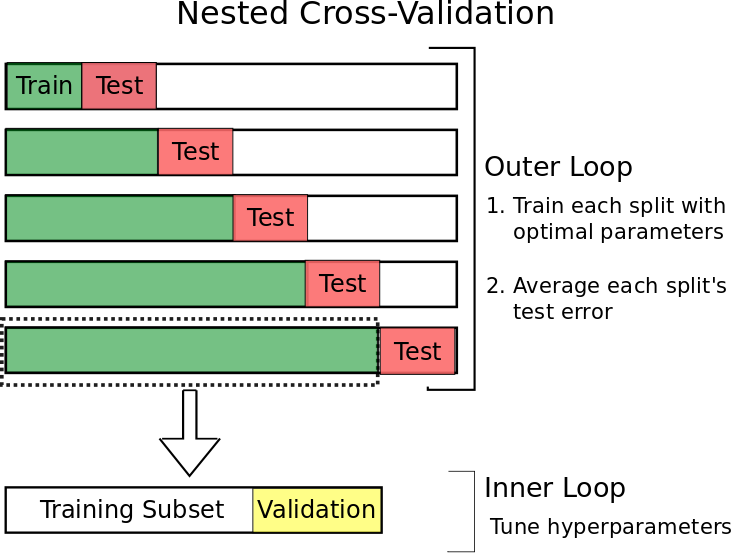

In [489]:
pred = "y+5"

cv = TimeSeriesSplit(n_splits=5)

df_past2 = df_past.loc[df_past[pred].notna()]

X = df_past2.drop(columns=["y+1","y+2","y+3","y+4","y+5"])

dtrain = xgb.DMatrix(X, df_past2[pred]) 
params = { 'learning_rate': 0.1, 'max_depth': 6}
cv_results = xgb.cv(params=params, dtrain=dtrain, folds=cv, metrics=['rmse'], early_stopping_rounds=10, num_boost_round=1000, verbose_eval=True)

[0]	train-rmse:89150.98290+1145.18261	test-rmse:85928.10268+2582.83492
[1]	train-rmse:80327.92469+1023.70218	test-rmse:77456.36073+2304.22219
[2]	train-rmse:72396.17536+913.27579	test-rmse:69849.76808+2049.80756
[3]	train-rmse:65265.85962+812.18877	test-rmse:63044.63207+1813.56981
[4]	train-rmse:58857.56735+719.24708	test-rmse:56922.46870+1601.89531
[5]	train-rmse:53100.64113+634.19166	test-rmse:51431.36337+1414.69320
[6]	train-rmse:47931.85396+558.19668	test-rmse:46520.50676+1250.20187
[7]	train-rmse:43292.12248+485.08745	test-rmse:42106.57445+1097.66829
[8]	train-rmse:39131.10318+419.74281	test-rmse:38135.93210+922.07939
[9]	train-rmse:35399.58396+355.17260	test-rmse:34623.91617+789.28935
[10]	train-rmse:32060.74162+297.42310	test-rmse:31467.62838+688.46491
[11]	train-rmse:29070.47801+245.32830	test-rmse:28696.09327+584.63604
[12]	train-rmse:26400.56445+195.37919	test-rmse:26221.05119+553.50070
[13]	train-rmse:24014.76919+148.81379	test-rmse:24044.46739+573.70907
[14]	train-rmse:2188

In [490]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
42,7181.279099,670.322304,10456.913509,1003.414310
43,7136.331964,664.287458,10450.749320,1005.751788
44,7103.171260,670.860303,10444.253404,1004.105407
45,7060.937710,677.048792,10436.183970,1005.604463
46,7029.196372,676.390133,10435.233967,1007.784619


Les meilleures itérations sont :
</br>y+1 : 45
</br>y+2 : 35
</br>y+3 : 44
</br>y+4 : 37
</br>y+5 : 46

In [491]:
dico_best = {1 : 45, 2 : 35, 3 : 44, 4 : 37, 5 : 46}

#### Split

Nous allons maintenant récupérer les 5 derniers tours de chaque GP et les placer dans un dataframe de test.
Evidemment, nous les retirerons du train.

In [492]:
#je recupere ici n tours de chaque course pour mon test
df_past2["rleId"] = df_past2.groupby(["raceId","driverId"]).cumcount(ascending=False)
train = df_past2[df_past2["rleId"]>5]
test = df_past2[df_past2["rleId"]<=5]

print(df_past2.shape)
print(train.shape)
print(test.shape)

(244615, 103)
(215994, 103)
(28621, 103)


#### Model fit

Nous allons ensuite fit notre modèle en récupérant le nombre d'itérations obtenu précedemment.

In [493]:
params = { 'learning_rate': 0.1, 'max_depth': 6, "objective":"reg:squarederror"}

X = train.drop(columns=["y+1","y+2","y+3","y+4","y+5"])
dtrain = xgb.DMatrix(X, train["y+1"]) 

model = xgb.train(params=params, dtrain=dtrain, num_boost_round=45,verbose_eval=True)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

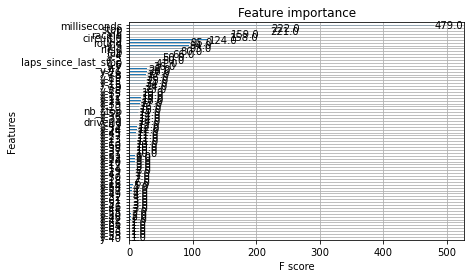

In [494]:
plot_importance(model) #Quelles features ont le plus d'impact sur mon modèle ?

#### Prediction

La prédiction est toute simple, nous rappelons qu'ici, nous prédisons pour chaque GP 5 fois le prochain tour, et non 1 fois les 5 prochains tours

In [495]:
x = test.drop(columns=["y+1","y+2","y+3","y+4","y+5"])
dtest = xgb.DMatrix(x, test[pred])
test["pred"] = model.predict(dtest)
test

,raceId,circuitId,driverId,lap,year,round,milliseconds,nb_stop,stop,laps_since_last_stop,...,y-80,y-81,y-82,y-83,y-84,y-85,y-86,y-87,rleId,pred
47,841,1,1,48,2011,1,90785,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,90339.195312
48,841,1,1,49,2011,1,90753,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,90209.710938
49,841,1,1,50,2011,1,91010,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,90682.421875
50,841,1,1,51,2011,1,91312,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,90666.140625
51,841,1,1,52,2011,1,91629,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,91507.070312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268870,1096,24,855,48,2022,22,90432,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,90083.125000
268871,1096,24,855,49,2022,22,90583,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,90139.617188
268872,1096,24,855,50,2022,22,90223,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,90005.773438
268873,1096,24,855,51,2022,22,90109,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,89637.046875


### Resultat

Observons la prédiction sur la performance de Ocon à Abu Dhabi en 2022

In [496]:
df_result_pred = test.loc[(test["raceId"]==1096) & (test["driverId"]==839)]
df_train = train.loc[(train["raceId"]==1096) & (train["driverId"]==839)]
df_result_pred

,raceId,circuitId,driverId,lap,year,round,milliseconds,nb_stop,stop,laps_since_last_stop,...,y-80,y-81,y-82,y-83,y-84,y-85,y-86,y-87,rleId,pred
268296,1096,24,839,48,2022,22,89707,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,89262.062500
268297,1096,24,839,49,2022,22,89641,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,89160.140625
268298,1096,24,839,50,2022,22,89848,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,89332.570312
268299,1096,24,839,51,2022,22,89502,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,88911.359375
268300,1096,24,839,52,2022,22,89611,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,89083.429688
268301,1096,24,839,53,2022,22,89506,2,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,88911.359375


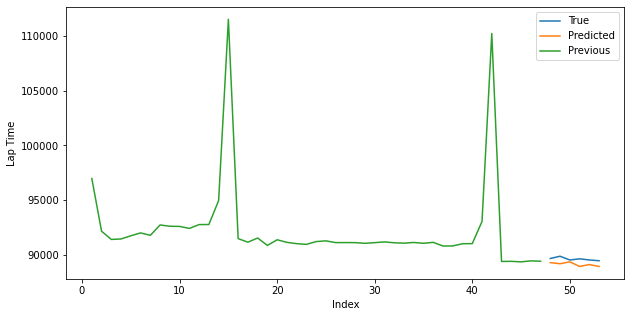

In [497]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df_result_pred["lap"], df_result_pred['y+1'], label='True')
ax.plot(df_result_pred["lap"], df_result_pred['pred'], label='Predicted')
ax.plot(df_train["lap"], df_train['milliseconds'], label='Previous')
ax.set_xlabel('Index')
ax.set_ylabel('Lap Time')
ax.legend()

plt.show()

On observe que la prédiction semble relativement proche de la réalité.

Maintenant, je vais essayer de calculer une fois les 5 tours suivants, pour cela j'entraîne 5 modèles différents, prédisant chacun un tour à horizon n

In [498]:
params = { 'learning_rate': 0.1, 'max_depth': 6, "objective":"reg:squarederror"}
#je recupere ici n tours de chaque course pour mon test
df_past["rleId"] = df_past.groupby(["raceId","driverId"]).cumcount(ascending=False)
train = df_past[df_past["rleId"]>8]
test = df_past[df_past["rleId"]==8]
test_result = test.copy()

for n in range(1,6):
    pred = "y+"+str(n)

    X = train.loc[train[pred].notna()].drop(columns=["y+1","y+2","y+3","y+4","y+5"])
    x = test.loc[test[pred].notna()].drop(columns=["y+1","y+2","y+3","y+4","y+5"])

    dtrain = xgb.DMatrix(X, train[pred]) 

    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=dico_best[n],verbose_eval=True)

    dtest = xgb.DMatrix(x, test[pred])
    test_result["pred_y+"+str(n)] = model.predict(dtest)

test_result

,raceId,circuitId,driverId,lap,year,round,milliseconds,nb_stop,stop,laps_since_last_stop,...,y-84,y-85,y-86,y-87,rleId,pred_y+1,pred_y+2,pred_y+3,pred_y+4,pred_y+5
49,841,1,1,50,2011,1,91010,2,False,0,...,NaN,NaN,NaN,NaN,8,90702.523438,90030.835938,91080.281250,90429.734375,90979.164062
106,841,1,2,49,2011,1,94204,2,False,0,...,NaN,NaN,NaN,NaN,8,94070.554688,93257.093750,94242.406250,93028.578125,93151.562500
128,841,1,3,14,2011,1,94135,0,False,14,...,NaN,NaN,NaN,NaN,8,94945.101562,94196.218750,96031.351562,94737.500000,94841.445312
186,841,1,4,50,2011,1,89867,3,False,0,...,NaN,NaN,NaN,NaN,8,89560.687500,88486.382812,89437.570312,88835.429688,89374.062500
205,841,1,5,11,2011,1,95907,0,False,11,...,NaN,NaN,NaN,NaN,8,96032.601562,95548.750000,97408.203125,96313.734375,97792.859375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268644,1096,24,848,49,2022,22,91795,2,False,0,...,NaN,NaN,NaN,NaN,8,91392.953125,90550.640625,91529.453125,91904.531250,93126.945312
268699,1096,24,849,47,2022,22,90577,2,False,0,...,NaN,NaN,NaN,NaN,8,90128.429688,89071.734375,90426.046875,89302.250000,90442.515625
268757,1096,24,852,50,2022,22,90760,2,False,0,...,NaN,NaN,NaN,NaN,8,90078.507812,88742.679688,90012.406250,89425.859375,92062.679688
268814,1096,24,854,49,2022,22,91623,2,False,0,...,NaN,NaN,NaN,NaN,8,91392.953125,90342.359375,91294.015625,90273.437500,92689.234375


In [499]:
test = test_result.copy()
df_result_pred = test.loc[(test["raceId"]==1096) & (test["driverId"]==839)][["pred_y+1","pred_y+2","pred_y+3","pred_y+4","pred_y+5"]].reset_index(drop=True)
df_result = test.loc[(test["raceId"]==1096) & (test["driverId"]==839)][["y+1","y+2","y+3","y+4","y+5"]].reset_index(drop=True)

df_train = train.loc[(train["raceId"]==1096) & (train["driverId"]==839)]
df_result_pred = df_result_pred.transpose().reset_index(drop=True).rename(columns={0:"pred"})
df_result_pred["lap"] = df_train["lap"].max() + df_result_pred.index + 1
df_result = df_result.transpose().reset_index(drop=True).rename(columns={0:"reel"})
df_result["lap"] = df_train["lap"].max() + df_result.index + 1
result = df_result.merge(df_result_pred, on="lap")
result["diff"] = abs(result["reel"]-result["pred"])/1000
result

,reel,lap,pred,diff
0,89502.0,50,89322.460938,0.179539
1,89611.0,51,88275.914062,1.335086
2,89506.0,52,89065.664062,0.440336
3,89434.0,53,88441.531250,0.992469
4,89491.0,54,91141.179688,1.650180


### Resultat

Observer le resultat sur un simple grand prix n'a pas beaucoup de sens, mais nous permets de voir concrètement la prédiction.
On remarquera donc que la différence entre la prédiction et la réalité varie entre 0.1 et 1.8 secondes...

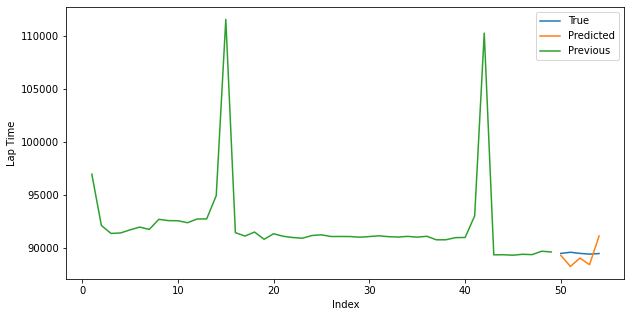

In [500]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(result["lap"], result["reel"], label='True')
ax.plot(result["lap"], result["pred"], label='Predicted')
ax.plot(df_train["lap"], df_train['milliseconds'], label='Previous')
ax.set_xlabel('Index')
ax.set_ylabel('Lap Time')
ax.legend()

plt.show()

## Conclusion

Après l'étude de modèles de régression classiques, puis de modèles de Timeseries, observer le résultat d'XGBoost etait très interessant.
La méthode, nottament avec les "shifts" est complètement différente, pourtant les résultats sont relativement proches.

Il semble cependant que le modèle mathématique de TimeSeries ARIMA était le plus efficace sur l'observation d'un seul grand prix.


Avec plus de temps, de nombreux autres paramètres pourraient être prits en compte, à commencer par la météo, ou le type de gommes (malheuresement non disponibles sur ces datasets)

Ces deux features pourraient drastiquement améliorer les résultats, et je compte tenter de les ajouter par la suite.

Il est évident que les données de télémétrie des deux voitures lors de la course seraient également une mine d'or pour réussir cette prédiction.

Merci pour votre lecture, je serai ravi de discuter plus longuement de ce projet ainsi que de tous les autres possibles en lien avec ce sport si passionant !